## Feature Extaction Test

In [1]:
import sys; sys.path.insert(0, '..')
from database.dataset import *

from feature_extraction.feature_extraction import CandidatesFeatureExtraction
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from general_utils.plots import plot_bboxes_over_image, simple_im_show, simple_im_show2
from metrics.metrics import get_tp_fp_fn, quick_circle_comparison, circle_comparison
import matplotlib.pyplot as plt
import pickle
from skimage.feature import graycomatrix,graycoprops
from general_utils.utils import min_max_norm
from general_utils.utils import crop_center_coords
import pywt


### Database initialization

In [2]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='image',
        max_lesion_diam_mm=1.0,
        partitions=['train'],
        extract_patches=True,
        extract_patches_method='all',  # 'centered'
        patch_size=256,
        stride=256,
        min_breast_fraction_roi=0.5,
        normalize=None,
        n_jobs=-1,
)

### Detectors Parameters and initialization

In [3]:
dehazing_params = {'omega': 0.9, 'window_size': 11, 'radius': 40, 'eps': 1e-5}

hough1_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 8,  'minRadius': 2, 'maxRadius': 20}

hough2_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 10,  'minRadius': 2, 'maxRadius': 20}

back_ext_radius = 50

erosion_iter = 20
erosion_size = 5


hd = HoughCalcificationDetection(dehazing_params, back_ext_radius,
                                 Path.cwd().parent / 'data/hough_img',    # "/media/vzalevskyi/DATA/ProjectsData/calc-det/no_dehaizing",
                                 hough1_params, hough2_params,
                                 erosion_iter=erosion_iter,
                                 erosion_size=erosion_size)


### Features test

In [4]:
idx = 0
db_sample = db[idx]
image = db_sample['img']
image_id = db.df.iloc[idx].img_id
image_mask = db_sample['lesion_mask']
cfe  = CandidatesFeatureExtraction(patch_size=14)

# candidate selection
h1_circles = hd.detect(image, image_id, load_processed_images=True, hough2=False)[0]

# feature extraction
res = pd.DataFrame(cfe.extract_features(h1_circles, image, image_mask,fp2tp_sample=None))
res['img_id'] = image_id

In [5]:
res[]

(1501, 3)

In [5]:
res.describe()

patch_mean_LL1  patch_skew_LL1  patch_std_LL1  patch_kur_LL1  \
count     1501.000000     1501.000000    1501.000000    1501.000000   
mean         1.159920        0.052594       0.033883      -0.292464   
std          0.114884        0.482313       0.014154       0.817936   
min          0.741978       -1.967636       0.008912      -1.715417   
25%          1.082921       -0.241221       0.024693      -0.789476   
50%          1.160541        0.032547       0.030715      -0.454901   
75%          1.238209        0.349017       0.039459      -0.019443   
max          1.749337        2.360321       0.158256       6.311346   

       patch_entropy_LL1  patch_uniformity_LL1  patch_relsmooth_LL1  \
count        1501.000000           1501.000000          1501.000000   
mean            5.558546              0.021566             0.032596   
std             0.062044              0.001266             0.012858   
min             4.735926              0.020408             0.008833   
25%             5.533077              0.020408             0.024098   
50%             5.573894              0.021241             0.029800   
75%             5.614710              0.022074             0.037961   
max             5.614710              0.038265             0.136633   

       patch_mean_LH1  patch_skew_LH1  patch_std_LH1  ...  pi_o2_img_max  \
count     1501.000000     1501.000000    1501.000000  ...    1501.000000   
mean        -0.000093        0.013077       0.011229  ...       0.009147   
std          0.002697        0.348199       0.002006  ...       0.003011   
min         -0.011939       -1.282765       0.005149  ...       0.005952   
25%         -0.001728       -0.213963       0.009949  ...       0.005952   
50%         -0.000079        0.024177       0.011166  ...       0.011905   
75%          0.001477        0.223023       0.012344  ...       0.011905   
max          0.010527        1.221033       0.037078  ...       0.023810   

       pi_o2_img_mean  pi_o2_img_range  pi_o2_img_mean_abs_deviation  \
count    1.501000e+03      1501.000000                  1.501000e+03   
mean     1.525879e-05         0.009147                  3.043983e-05   
std      1.561852e-21         0.003011                  1.808062e-09   
min      1.525879e-05         0.005952                  3.043935e-05   
25%      1.525879e-05         0.005952                  3.043935e-05   
50%      1.525879e-05         0.011905                  3.043981e-05   
75%      1.525879e-05         0.011905                  3.043981e-05   
max      1.525879e-05         0.023810                  3.047287e-05   

       pi_o2_img_rms  pi_o2_img_std  pi_o2_img_skew  pi_o2_img_kurt  \
count    1501.000000    1501.000000     1501.000000     1501.000000   
mean        0.000303       0.000303       19.966287      403.800521   
std         0.000005       0.000005        0.453188       27.395895   
min         0.000301       0.000301       19.674801      385.097808   
25%         0.000301       0.000301       19.674801      385.097808   
50%         0.000303       0.000303       20.021579      407.765856   
75%         0.000303       0.000303       20.021579      407.765856   
max         0.000399       0.000398       26.070446      854.993817   

       patch_mask_intersection      img_id  
count              1501.000000      1501.0  
mean                  0.153897  20586908.0  
std                   2.803979         0.0  
min                   0.000000  20586908.0  
25%                   0.000000  20586908.0  
50%                   0.000000  20586908.0  
75%                   0.000000  20586908.0  
max                  84.000000  20586908.0  

[8 rows x 154 columns]

In [6]:
res.iloc[:,list(np.where((res == 0).all())[0])]

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[1501 rows x 0 columns]

In [7]:
res.columns[list(np.where((res == 0).all())[0])]

Index(['0_img_min', '0_img_10th_perc', '0_img_90th_perc', '0_img_median',
       '0_img_inter_quartile_range', '0_img_robust_mean_abs_deviation',
       'pi_o4_img_min', 'pi_o4_img_10th_perc', 'pi_o4_img_90th_perc',
       'pi_o4_img_median', 'pi_o4_img_inter_quartile_range',
       'pi_o4_img_robust_mean_abs_deviation', 'pi_o2_img_min',
       'pi_o2_img_10th_perc', 'pi_o2_img_90th_perc', 'pi_o2_img_median',
       'pi_o2_img_inter_quartile_range',
       'pi_o2_img_robust_mean_abs_deviation'],
      dtype='object')

In [39]:
idx = 0
db_sample = db[idx]
image = db_sample['img']
image_id = db.df.iloc[idx].img_id
image_mask = db_sample['lesion_mask']
patch_x1, patch_x2, patch_y1, patch_y2 = crop_center_coords(1042, 2295, image.shape, 30//2)
image_patch = image[patch_y1:patch_y2, patch_x1:patch_x2]
#cfe  = CandidatesFeatureExtraction(patch_size=14)


glcm_decomp = graycomatrix(min_max_norm(image_patch,max_val=255).astype(np.uint8),[2],[0,np.pi, np.pi/4, np.pi/2],normed=True)
LL1,(LH1,HL1,HH1) = pywt.dwt2(min_max_norm(image_patch),'haar')
glcm_LL1 = graycomatrix(min_max_norm(LL1,max_val=255).astype(np.uint8),[2],[0,np.pi, np.pi/4, np.pi/2],normed=True)

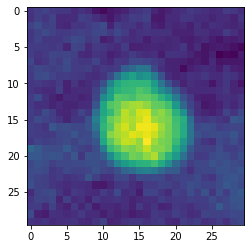

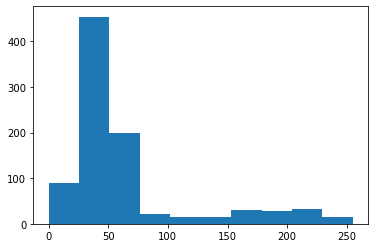

In [40]:
plt.imshow(min_max_norm(image_patch,max_val=255).astype(np.uint8))
plt.show()
min_max_norm(image_patch,max_val=255).astype(np.uint8).max()
plt.hist(min_max_norm(image_patch,max_val=255).astype(np.uint8).flatten())
plt.show()

In [41]:
(glcm_LL1[:,:,0,0] == glcm_LL1[:,:,0,1]).sum()

65208

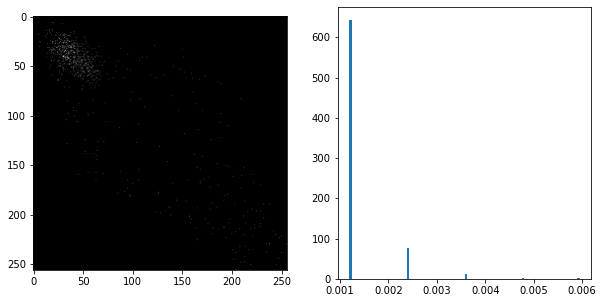

64803
max: 0.005952380952380952 0.0
mean: 1.52587890625e-05


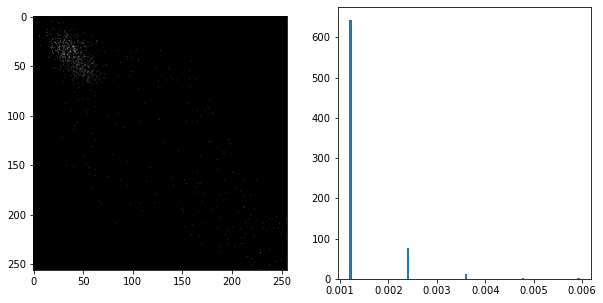

64803
max: 0.005952380952380952 0.0
mean: 1.52587890625e-05


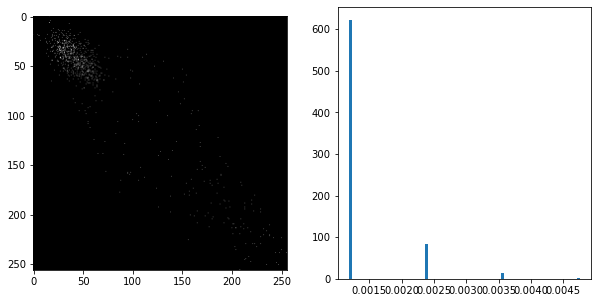

64814
max: 0.0047562425683709865 0.0
mean: 1.5258789062499998e-05


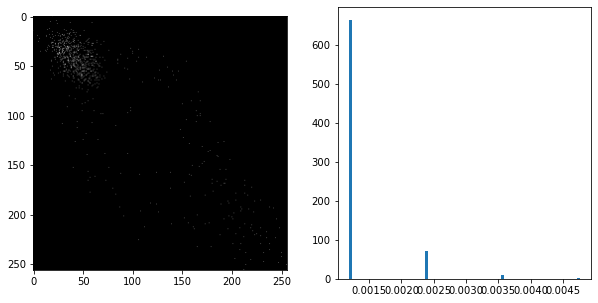

64791
max: 0.004761904761904762 0.0
mean: 1.52587890625e-05


In [46]:
for idx in range(4):
    glcm = glcm_decomp[:,:,0,idx]
    f,ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(glcm,cmap='gray')
    ax[1].hist(glcm[(glcm != 0)].flatten(),bins=100) #(glcm < 25) & 
    plt.show()
    print((glcm==0).sum())
    print(f'max: {glcm.max()}',np.quantile(glcm, q=0.1))
    print(f'mean: {glcm.mean()}')

### Detector initialization

In [4]:
# FE class initialization
cfe  = CandidatesFeatureExtraction(patch_size=14)


### FE

In [5]:
fdf = []
for idx in tqdm(range(len(db))): # range(len(db))
    # extracting data
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db.df.iloc[idx].img_id
    image_mask = db_sample['lesion_mask']

    # candidate selection
    h1_circles = hd.detect(image, image_id, load_processed_images=True, hough2=False)[0]

    # feature extraction
    res = pd.DataFrame(cfe.extract_features(h1_circles, image, image_mask,fp2tp_sample=None))
    res['img_id'] = image_id
    
    # classification
    
    fdf.append(res)

100%|██████████| 154/154 [4:16:23<00:00, 99.89s/it]   


In [6]:
pd.to_pickle(fdf,"wavelet_glcm_alltrain_allcand_newf_p14")

In [66]:
data['label'] = np.where(data.patch_mask_intersection > 0,1,0)
data

patch_mean_LL1  patch_skew_LL1  patch_std_LL1  patch_kur_LL1  \
124        0.973821        0.670769       0.025556       0.370456   
123        1.393384        0.357284       0.043550      -0.032247   
19         1.482471        1.991780       0.044531       7.173345   
82         0.960500       -0.198632       0.126107      -1.678250   
64         1.120551        0.068118       0.037931      -0.615602   

     patch_entropy_LL1  patch_uniformity_LL1  patch_relsmooth_LL1  \
124           7.575960              0.005551             0.024920   
123           7.641537              0.005235             0.041733   
19            7.504849              0.005867             0.042633   
82            7.682627              0.005077             0.111985   
64            7.579315              0.005590             0.036545   

     patch_mean_LH1  patch_skew_LH1  patch_std_LH1  ...  \
124       -0.000605       -0.056924       0.004498  ...   
123       -0.001608       -0.176221       0.014319  ...   
19        -0.000268        0.319564       0.009027  ...   
82        -0.004300       -0.718022       0.007385  ...   
64        -0.001518       -0.080027       0.011368  ...   

     patch_glcm_correlation_HH1  patch_glcm_homogeneity_HH1  \
124                    0.127433                    0.025075   
123                   -0.027901                    0.011038   
19                    -0.074022                    0.031157   
82                    -0.064574                    0.059207   
64                    -0.075084                    0.021586   

     patch_glcm_contrast_HH1  patch_glcm_dissimilarity_HH1  \
124              4655.471795                     53.656410   
123              4782.738462                     57.610256   
19               4579.328205                     54.794872   
82               3932.574359                     51.076923   
64               3322.820513                     45.989744   

     patch_glcm_ASM_HH1  patch_glcm_entropy_HH1  patch_glcm_uniformity_HH1  \
124            0.005549           -3.203427e-16                        1.0   
123            0.005233           -3.203427e-16                        1.0   
19             0.005233           -3.203427e-16                        1.0   
82             0.007074           -3.203427e-16                        1.0   
64             0.005181           -3.203427e-16                        1.0   

     patch_mask_intersection    img_id  label  
124                      0.0  24065251      0  
123                      0.0  24055806      0  
19                       1.0  20587466      1  
82                       0.0  20587466      0  
64                       0.0  24055149      0  

[5 rows x 83 columns]

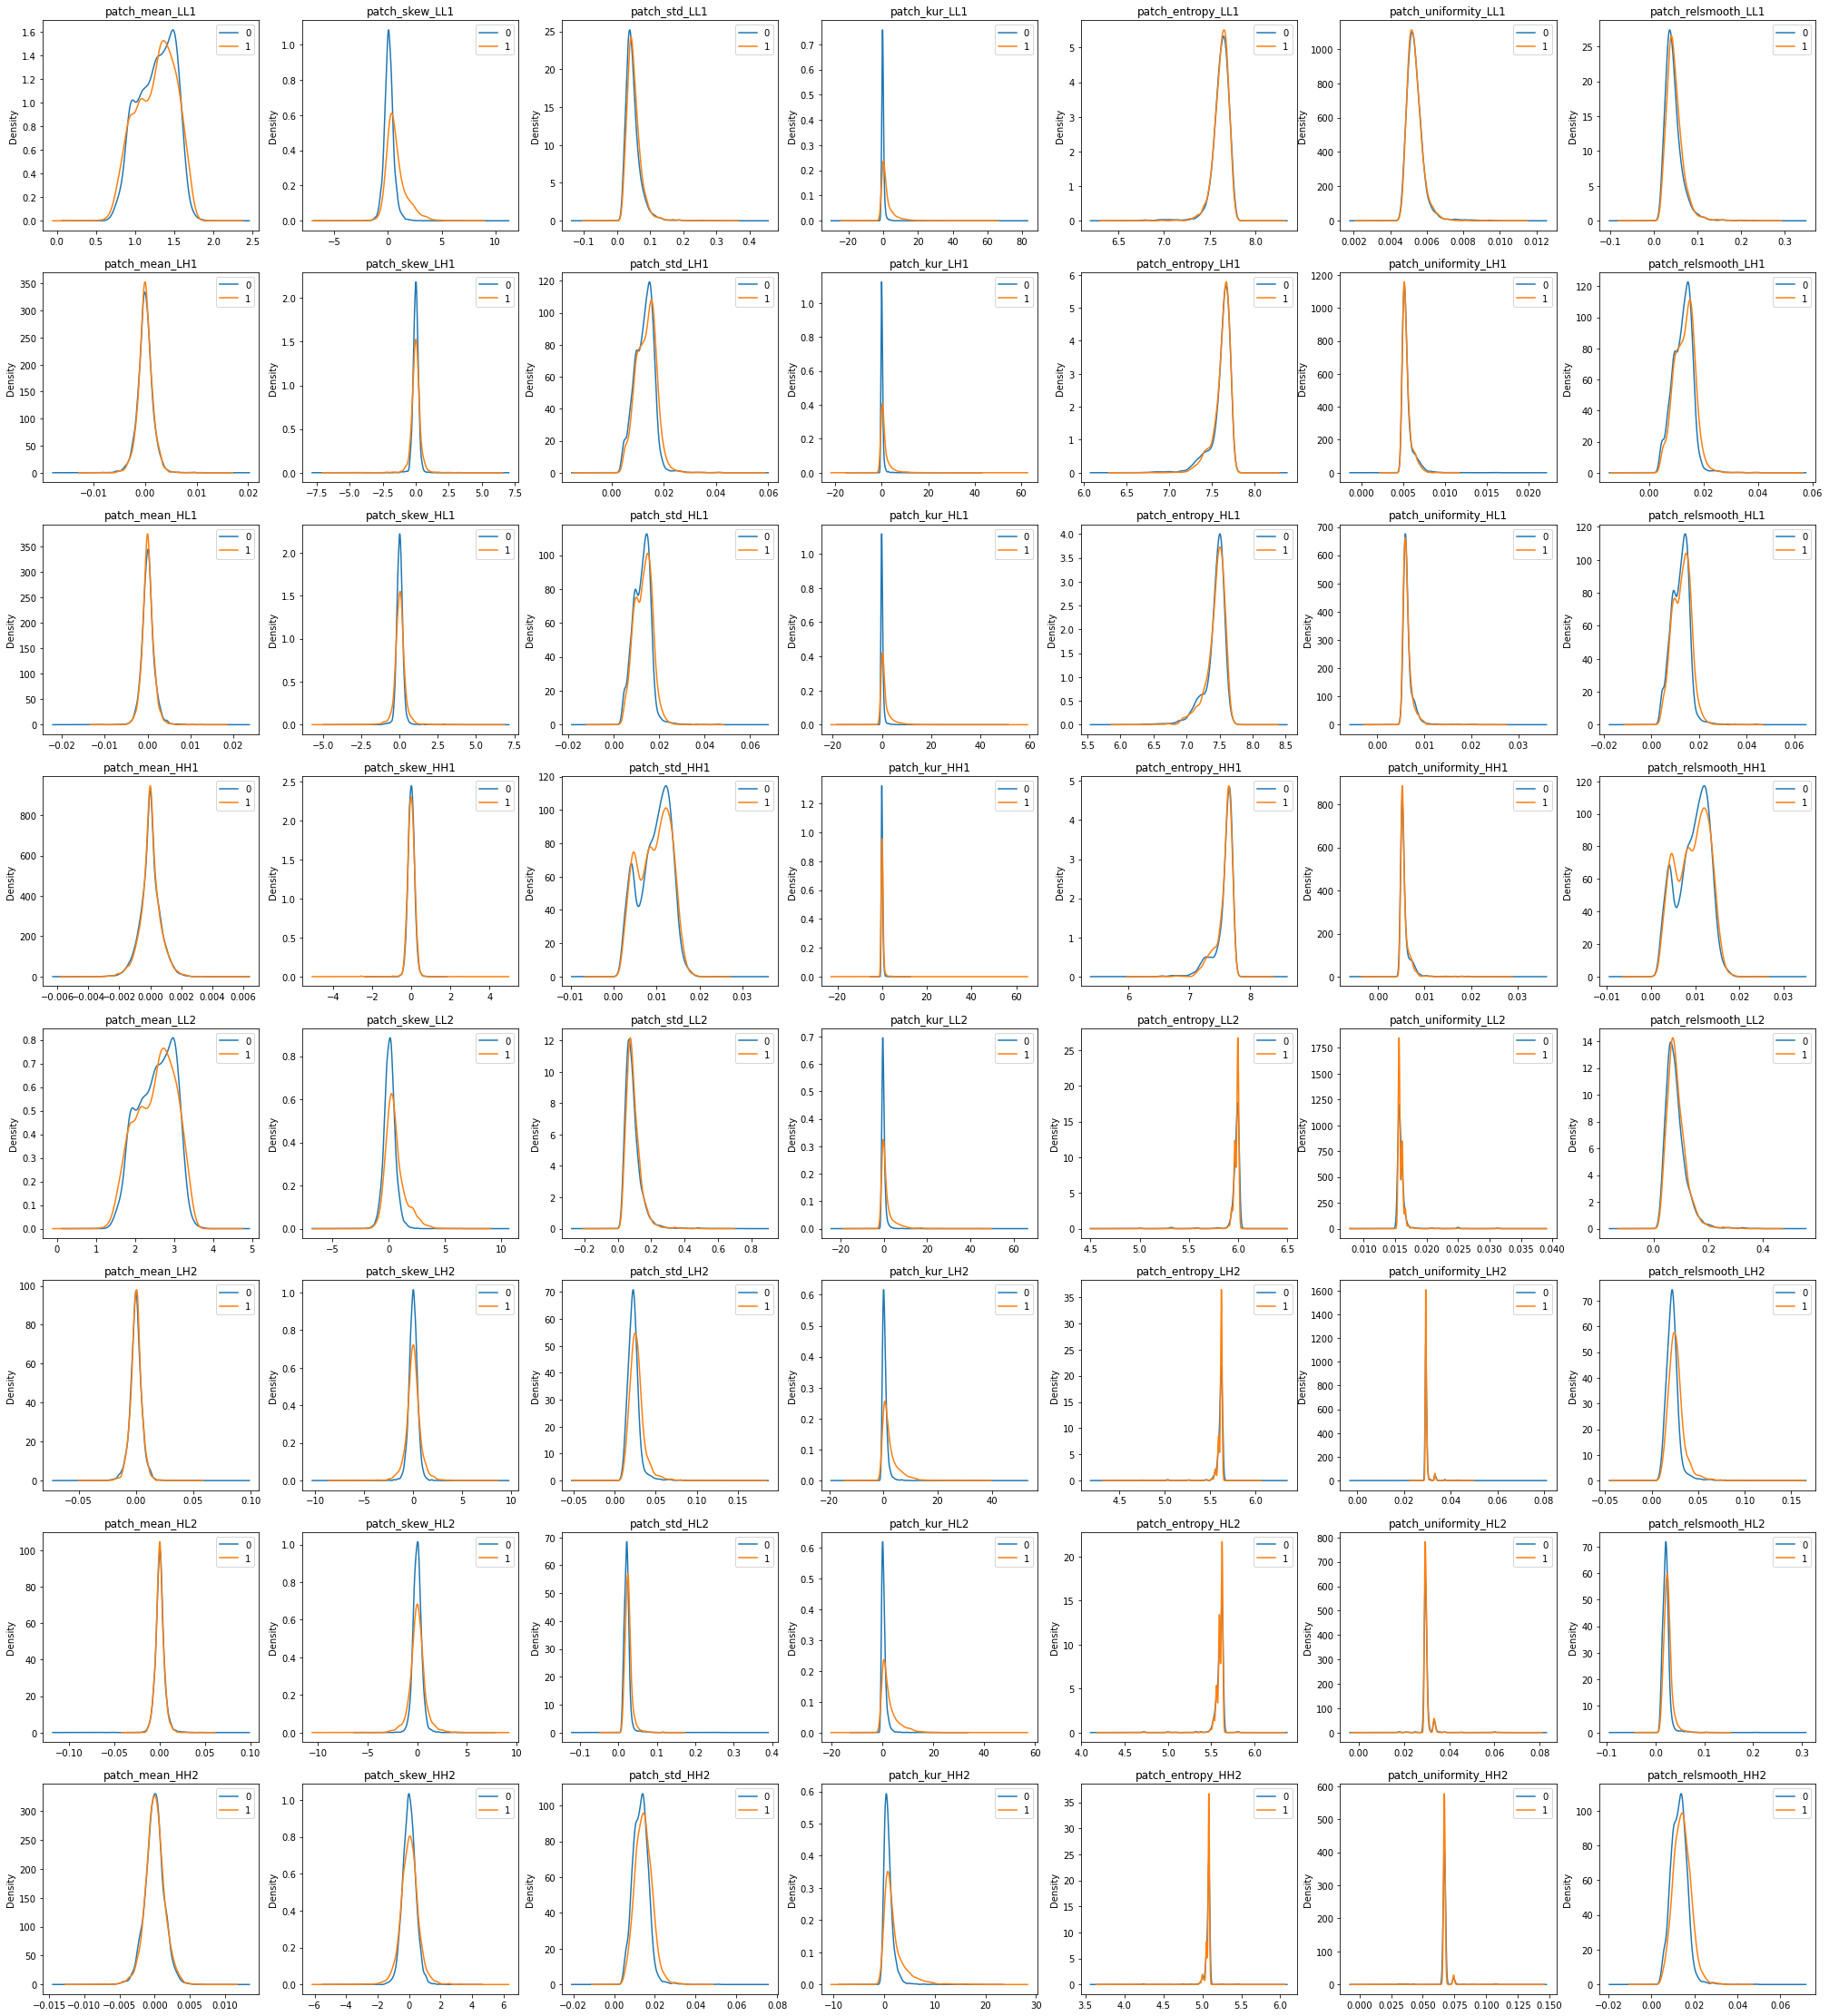

In [86]:
# f,ax = plt.subplots(2,7,figsize=(35,10))
# for col_indx in range(7):
#     data.groupby("label")[data.columns[col_indx]].plot(kind='kde',legend=True,ax=ax[0,col_indx])
#     ax[0,col_indx].set_title(data.columns[col_indx])
# for col_indx in range(7):
#     data.groupby("label")[data.columns[col_indx+7]].plot(kind='kde',legend=True,ax=ax[1,col_indx])
#     ax[1,col_indx].set_title(data.columns[col_indx+7])
    
f,ax = plt.subplots(8,7,figsize=(35,40))
for col_indx in range(7):
    for row in range(8):
        data.groupby("label")[data.columns[col_indx+7*row]].plot(kind='kde',legend=True,ax=ax[row,col_indx])
        ax[row,col_indx].set_title(data.columns[col_indx+7*row])

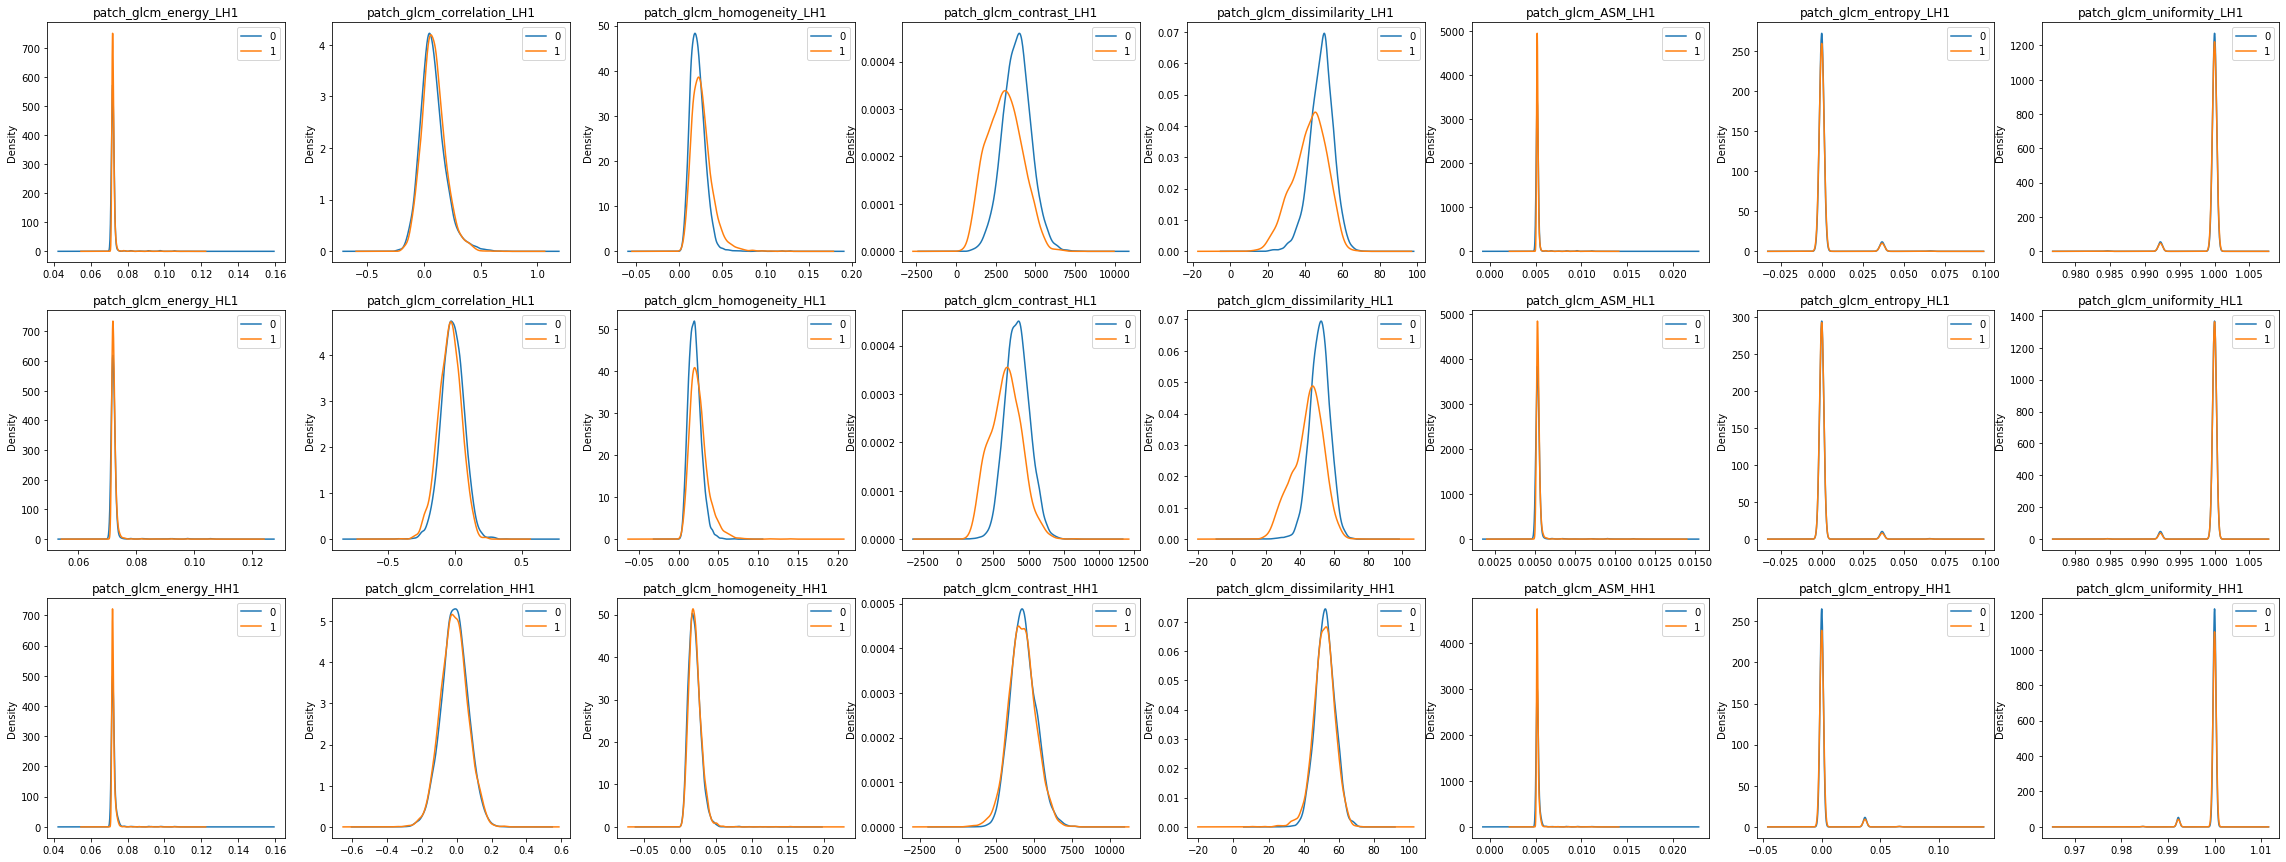

In [91]:
f,ax = plt.subplots(3,8,figsize=(40,15))
for col_indx in range(8):
    for row in range(3):
        data.groupby("label")[data.columns[col_indx+8*row+56]].plot(kind='kde',legend=True,ax=ax[row,col_indx])
        ax[row,col_indx].set_title(data.columns[col_indx+8*row+56])

### Classification

In [2]:
from sklearn.svm import SVC

from sklearn.metrics import f1_score, roc_auc_score

from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier

In [50]:
with open('wavelet_alltrain_allcand_newf_p14', 'rb') as f:
    x = pickle.load(f)


In [51]:
data = pd.concat(x).sample(frac=1) # merge and shuffle
#,'patch_glcm_autocorrelation_HH1','patch_glcm_autocorrelation_HL1','patch_glcm_autocorrelation_LH1',
                                # 'patch_glcm_sum_squares_HH1','patch_glcm_sum_squares_HL1','patch_glcm_sum_squares_LH1'])
data 

patch_mean_LL1  patch_skew_LL1  patch_std_LL1  patch_kur_LL1  \
719         1.344594        1.095868       0.032878       1.100111   
427         1.134030        0.669534       0.036160       0.081022   
1489        0.940231        0.127326       0.019920      -0.129348   
958         1.434838        0.933706       0.044153       1.717632   
731         1.471744       -0.321570       0.049948      -0.621389   
...              ...             ...            ...            ...   
205         1.464086        0.345036       0.059639      -1.104685   
1134        0.761547        0.848448       0.039604      -0.343896   
815         1.215686        0.434201       0.082646      -1.284668   
618         1.454875        0.094884       0.030693      -0.492916   
547         1.227856       -0.277318       0.022256      -0.533031   

      patch_entropy_LL1  patch_uniformity_LL1  patch_relsmooth_LL1  \
719            5.436039              0.024573             0.031831   
427            5.614710              0.020408             0.034898   
1489           5.573894              0.021241             0.019531   
958            5.614710              0.020408             0.042286   
731            5.573894              0.021241             0.047572   
...                 ...                   ...                  ...   
205            5.573894              0.021241             0.056283   
1134           5.573894              0.021241             0.038095   
815            5.573894              0.021241             0.076337   
618            5.492261              0.022907             0.029779   
547            5.573894              0.021241             0.021771   

      patch_mean_LH1  patch_skew_LH1  patch_std_LH1  ...  \
719        -0.003411        0.565714       0.011269  ...   
427         0.002133       -0.304190       0.013315  ...   
1489        0.002148       -0.195650       0.009345  ...   
958         0.000290        0.343529       0.010267  ...   
731        -0.002776        0.061681       0.012742  ...   
...              ...             ...            ...  ...   
205        -0.004781        0.001201       0.014381  ...   
1134       -0.004024       -0.430733       0.006879  ...   
815        -0.005952       -0.393753       0.014727  ...   
618        -0.001771       -0.207477       0.012906  ...   
547        -0.000910       -0.178960       0.015114  ...   

      patch_glcm_homogeneity_HH1_pi_o2  patch_glcm_contrast_HH1_0  \
719                           0.001864                6441.600000   
427                           0.002564               10050.628571   
1489                          0.007112                7816.142857   
958                           0.007815                6396.885714   
731                           0.006616                3821.057143   
...                                ...                        ...   
205                           0.001458                6123.114286   
1134                          0.020043                8386.800000   
815                           0.009485                6405.028571   
618                           0.006279                5424.771429   
547                           0.018185                4837.742857   

      patch_glcm_contrast_HH1_pi_o4  patch_glcm_contrast_HH1_pi_o2  \
719                     7095.555556                    7840.771429   
427                     7018.638889                    9738.000000   
1489                    5755.305556                    4891.314286   
958                     6861.861111                    8883.771429   
731                     6153.250000                    6581.771429   
...                             ...                            ...   
205                     5498.250000                    9583.485714   
1134                    9277.194444                    9029.914286   
815                     5521.472222                    5704.571429   
618                     6576.444444                    6001.371429   
547 

In [52]:
data_backed_up = data.copy()

In [53]:
pos_data = data_backed_up[data_backed_up.patch_mask_intersection > 0]
neg_data = data_backed_up[data_backed_up.patch_mask_intersection == 0].sample(len(pos_data)*2)
data = pd.concat([pos_data,neg_data]).sample(frac=1)
data_test = data
data = data.drop(columns=['coordinates'])
data

patch_mean_LL1  patch_skew_LL1  patch_std_LL1  patch_kur_LL1  \
1252        0.793245        0.011205       0.012563       0.102287   
503         1.568704        0.311723       0.034937      -0.085473   
101         1.034802       -0.226824       0.146564      -1.431233   
206         1.486881        0.295068       0.035003      -0.564262   
124         1.409422        0.312069       0.029583      -0.790355   
...              ...             ...            ...            ...   
710         1.073480        1.620174       0.080664       1.908712   
1012        1.266841       -0.014834       0.034121       0.087750   
262         1.184379        0.184282       0.030516       1.204367   
1173        1.482852        0.220429       0.030752      -0.451152   
1091        1.344868        0.320487       0.028272      -0.142066   

      patch_entropy_LL1  patch_uniformity_LL1  patch_relsmooth_LL1  \
1252           5.492261              0.022907             0.012407   
503            5.614710              0.020408             0.033758   
101            5.573894              0.021241             0.127829   
206            5.614710              0.020408             0.033819   
124            5.573894              0.021241             0.028733   
...                 ...                   ...                  ...   
710            5.573894              0.021241             0.074643   
1012           5.533077              0.022074             0.032995   
262            5.573894              0.021241             0.029612   
1173           5.451445              0.023740             0.029834   
1091           5.533077              0.022074             0.027495   

      patch_mean_LH1  patch_skew_LH1  patch_std_LH1  ...  \
1252       -0.000164       -0.045031       0.007616  ...   
503         0.003652       -0.089401       0.015478  ...   
101         0.000854       -0.395955       0.037397  ...   
206         0.000712       -0.269589       0.013018  ...   
124         0.001585       -0.373648       0.013983  ...   
...              ...             ...            ...  ...   
710        -0.002088       -0.098737       0.019096  ...   
1012       -0.000594        0.412905       0.018155  ...   
262        -0.001552       -0.178690       0.011462  ...   
1173       -0.000166        0.533613       0.010013  ...   
1091       -0.002589        0.316577       0.012624  ...   

      patch_glcm_homogeneity_HH1_pi_o4  patch_glcm_homogeneity_HH1_pi_o2  \
1252                          0.006160                          0.030072   
503                           0.001911                          0.012123   
101                           0.012457                          0.008615   
206                           0.001319                          0.001099   
124                           0.005985                          0.018736   
...                                ...                               ...   
710                           0.089986                          0.002357   
1012                          0.004425                          0.014909   
262                           0.000778                          0.004931   
1173                          0.002362                          0.008788   
1091                          0.009279                          0.009438   

      patch_glcm_contrast_HH1_0  patch_glcm_contrast_HH1_pi_o4  \
1252                7485.285714                    7760.138889   
503                 4839.628571                    5298.527778   
101                 6068.314286                    9334.111111   
206                 9184.800000                    8323.361111   
124                 5586.028571                    4244.638889   
...                         ...                            ...   
710                 3584.400000                    4421.722222   
1012                7917.485714                    7103.194444   
262                 7579.800000                    7959.444444   
1173                7032.91428

In [41]:
len(data.img_id.unique())

154

In [70]:
f1_metrics = []
weird_px = []
fe_importances = []

for test_img_id in tqdm(data.img_id.unique()):
    train_df = data[data.img_id != test_img_id]
    test_df = data[data.img_id == test_img_id]

    train_X, train_y = train_df.drop(columns=['patch_mask_intersection','img_id']), (train_df.patch_mask_intersection>0).astype(int)
    test_X, test_y = test_df.drop(columns=['patch_mask_intersection','img_id']), (test_df.patch_mask_intersection>0).astype(int)

    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    test_X_scaled = scaler.transform(test_X)


    # svc = SVC(C=10, probability=False)
    # svc.fit(train_X_scaled, train_y)

    # train_y_predicted = svc.predict(train_X_scaled)
    # # train_y_predicted_proba = svc.predict_proba(train_X_scaled)
    
    # test_y_predicted = svc.predict(test_X_scaled)
    # # test_y_predicted_proba = svc.predict_proba(test_X_scaled)
    
    rfc = RandomForestClassifier(max_depth=5,n_jobs=-1)
    rfc.fit(train_X_scaled, train_y)
    fe_importances.append(rfc.feature_importances_)
    
    train_y_predicted = rfc.predict(train_X_scaled)
    test_y_predicted = rfc.predict(test_X_scaled)
    
    
    test_f1_score = f1_score(test_y, test_y_predicted)
    if test_f1_score == 0:
        weird_px.append((test_img_id,test_y_predicted,test_y))
    
    f1_metrics.append((f1_score(train_y, train_y_predicted), test_f1_score))
    # plt.boxplot(np.array(f1_metrics))
    # plt.show()
    # rocauc_metrics.append((roc_auc_score(train_y, train_y_predicted_proba), roc_auc_score(test_y, test_y_predicted_proba)))

  0%|          | 0/154 [00:00<?, ?it/s]/home/acortinau/anaconda3/envs/calc_det/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
 26%|██▌       | 40/154 [00:21<01:02,  1.81it/s]/home/acortinau/anaconda3/envs/calc_det/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
 32%|███▏      | 50/154 [00:26<00:58,  1.77it/s]/home/acortinau/anaconda3/envs/calc_det/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
 40%|████    

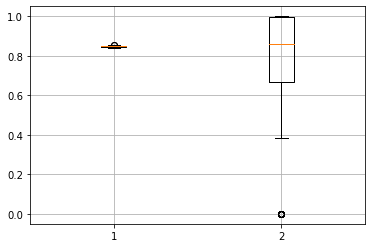

In [71]:
plt.boxplot(np.array(f1_metrics))
plt.grid('on')
plt.show()

In [56]:
np.array(f1_metrics)[:,1].std()

0.292112355066153

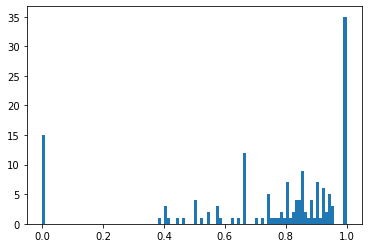

In [57]:
plt.figure()
plt.hist(np.array(f1_metrics)[:,1],bins=100)
plt.show()

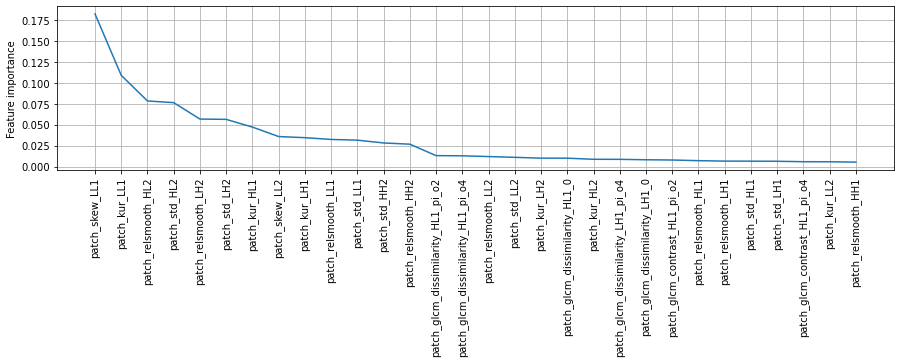

In [26]:
forest_importances = pd.DataFrame(fe_importances,columns=data.columns[:-2])

fe_sorted = forest_importances.mean().sort_values(ascending=False)

plt.figure(figsize=(15,3))
plt.plot(fe_sorted[:30])
plt.xticks(rotation=90)
plt.ylabel('Feature importance')
plt.grid("on")
plt.show()

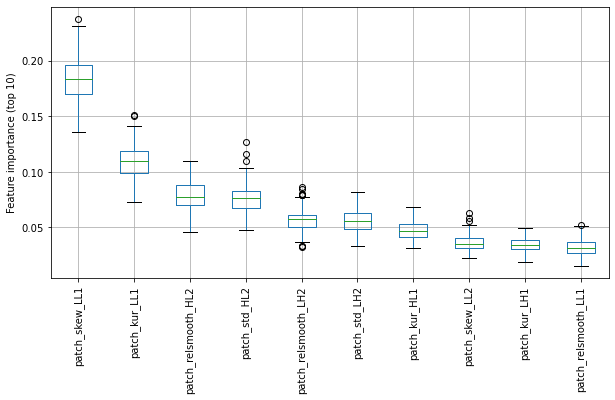

In [44]:
plt.figure(figsize=(10,5))
forest_importances[fe_sorted.index[:10]].boxplot()
plt.xticks(rotation=90)
plt.ylabel('Feature importance (top 10)')
plt.show()


In [25]:
np.array(f1_metrics)

array([[0.85229464, 0.38461538],
       [0.85185185, 0.79452055],
       [0.84686064, 0.66666667],
       [0.8530987 , 0.75862069],
       [0.85035809, 0.92307692],
       [0.85064443, 0.93333333],
       [0.84998129, 1.        ],
       [0.8481203 , 0.8       ],
       [0.85264342, 1.        ],
       [0.85090361, 0.75      ],
       [0.84857571, 0.85714286],
       [0.84926332, 0.95652174],
       [0.85388128, 0.42857143],
       [0.84419048, 1.        ],
       [0.85114361, 0.        ],
       [0.84672099, 0.87323944],
       [0.85037594, 0.30769231],
       [0.84720121, 0.94736842],
       [0.84598047, 0.        ],
       [0.84702336, 0.        ],
       [0.85276074, 0.84444444],
       [0.84885036, 0.85714286],
       [0.84603774, 0.5       ],
       [0.85190726, 1.        ],
       [0.84752176, 0.94736842],
       [0.84250474, 1.        ],
       [0.84935655, 0.84615385],
       [0.84825493, 0.95238095],
       [0.84354272, 0.8       ],
       [0.84480122, 0.9       ],
       [0.

In [73]:
weird_px[i][2].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [74]:
for i in range(15):
    if not np.any(weird_px[i][1]):
        print('patch count: ',weird_px[i][1].shape)
        print(f'px id: {weird_px[i][0]}')
        print(weird_px[i][1])
        print(weird_px[i][2].values)

patch count:  (37,)
px id: 24055904
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
patch count:  (17,)
px id: 24065611
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
patch count:  (17,)
px id: 22679008
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
patch count:  (36,)
px id: 24055877
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
patch count:  (30,)
px id: 22670177
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
patch count:  (8,)
px id: 26933830
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
patch count:  (15,)
px id: 22678518
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
patch count:  (16,)
px id: 20587994
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 

In [75]:
for i in range(15):
    if not np.any(weird_px[i][2]):
        #print('patch count: ',weird_px[i][1].shape)
        print(f'px id: {weird_px[i][0]}')
        #print(weird_px[i][1])
        print(weird_px[i][2].values)

px id: 24055904
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
px id: 20587320
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
px id: 22679008
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
px id: 24055877
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
px id: 22670177
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
px id: 22670147
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
px id: 26933830
[0 0 0 0 0 0 0 0]
px id: 20587994
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
px id: 22670094
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
px id: 22613676
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
px id: 20588562
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [76]:
for i in range(15):
    if np.any(weird_px[i][2]):
        #print('patch count: ',weird_px[i][1].shape)
        print(f'px id: {weird_px[i][0]}')
        #print(weird_px[i][1])
        print(weird_px[i][2].values)

px id: 24065611
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
px id: 22670301
[0 0 0 0 0 0 0 0 0 0 1 0]
px id: 22678518
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
px id: 24065557
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


In [63]:
# pos_data = all_data_df[all_data_df.patch_mask_intersection > 0]
# neg_data = all_data_df[all_data_df.patch_mask_intersection == 0].sample(len(pos_data)*2)
# data_test = pd.concat([pos_data,neg_data]).sample(frac=1)
px_bad_test = data_test.loc[data.img_id == 24055904, 'coordinates']
len(px_bad_test)

37

## NEW Features

### Wavelet

In [3]:
import pywt
from general_utils.utils import min_max_norm
from scipy.stats import kurtosis, skew
from skimage import feature
from general_utils.utils import crop_center_coords

In [22]:
idx = 1
wavelet = pywt.Wavelet('haar')

image = min_max_norm(db[idx]['img'])
patch = image[2600:2800,400:600]

def get_wavelet_features(patch:np.ndarray):
    eight_decomp = get_wavelet_decomp(patch)
    fo_features = {}
    for idx,single_decomp in enumerate(eight_decomp):
        fo_features = fo_features | wav_first_order(single_decomp,idx)
    #fo_features = [wav_first_order(single_decomp) for single_decomp in eight_decomp]
    #glcm_features = [wav_glcm_features(single_decomp) for single_decomp in eight_decomp[1:4]]
    glcm_features = {}
    for idx,single_decomp in enumerate(eight_decomp[1:4]):
        glcm_features = glcm_features | wav_glcm_features(single_decomp,idx)
    return fo_features | glcm_features

def get_wavelet_decomp(patch: np.ndarray,wavelet_type = 'haar'):
    LL1,(LH1,HL1,HH1) = pywt.dwt2(patch,wavelet) # coef_lv1
    LL2,(LH2,HL2,HH2) = pywt.dwt2(LL1,wavelet) # coef_lv2
    return [LL1,LH1,HL1,HH1,LL2,LH2,HL2,HH2]

def wav_first_order(single_decomp: np.ndarray,idx: int):
    decomp_names = ['LL1','LH1','HL1','HH1','LL2','LH2','HL2','HH2']
    patch_mean = np.mean(single_decomp)
    patch_std = np.std(single_decomp)
    patch_skew = skew(single_decomp.ravel())
    patch_kurt = kurtosis(single_decomp.ravel())
    patch_entropy,patch_unif = CandidatesFeatureExtraction.entropy_uniformity(single_decomp)
    patch_relsmooth = 1 - 1/(1+patch_std)
    return {f'patch_mean_{decomp_names[idx]}': patch_mean,
            f'patch_skew_{decomp_names[idx]}': patch_skew,
            f'patch_std_{decomp_names[idx]}': patch_std,
            f'patch_kur_{decomp_names[idx]}': patch_kurt,
            f'patch_entropy_{decomp_names[idx]}': patch_entropy, 
            f'patch_uniformity_{decomp_names[idx]}': patch_unif,
            f'patch_relsmooth_{decomp_names[idx]}': patch_relsmooth}
    
def wav_glcm_features(single_decomp: np.ndarray,idx: int):
    decomp_names = ['LH1','HL1','HH1']
    skimage_glcm_features = ['energy','correlation','homogeneity','contrast','dissimilarity','ASM']
    glcm_features_1 = {}
    single_decomp_glcm = feature.graycomatrix(min_max_norm(single_decomp,max_val=256).astype(np.uint8),[2],[0],normed=True)
    #for glcm in single_decomp_glcm[:,:,0,:]:
    for feature_name in skimage_glcm_features:
        feature_results = feature.graycoprops(single_decomp_glcm, prop=feature_name)
        for fv in feature_results.ravel(): #fv_idx, enumerate
            glcm_features_1[f'patch_glcm_{feature_name}_{decomp_names[idx]}'] = fv # _{fv_idx}
    glcm_features_2 = {}
    for glcm in single_decomp_glcm[:,:,0,:]: #enumerate fv_idx,
        entropy, uniformity = CandidatesFeatureExtraction.entropy_uniformity(glcm)
        # sum average?
        # sum entropy?
        # difference entropy?
        sum_squares = (glcm*(1- glcm.mean())**2).sum()
        # inverse_diff = 0
        idx_grid = np.indices((glcm.shape[0], glcm.shape[1]))
        autocorrelation = (idx_grid[0, :, :]*idx_grid[1, :, :]*glcm).sum()
        glcm_features_2[f'patch_glcm_entropy_{decomp_names[idx]}'] = entropy
        glcm_features_2[f'patch_glcm_uniformity_{decomp_names[idx]}'] = uniformity
        glcm_features_2[f'patch_glcm_sum_squares_{decomp_names[idx]}'] = sum_squares
        glcm_features_2[f'patch_glcm_autocorrelation_{decomp_names[idx]}'] = autocorrelation
    return glcm_features_1 | glcm_features_2  

In [24]:
def get_wavelet_features(patch:np.ndarray,directions=[0,np.pi]):
    """ Extracts features from an patch's haar 2-level wavelet decomposition (8 decompositions)
    First order statistics: mean, skewness, standard deviation, kurtosis, entropy, uniformity, relative smoothness
    GLCM features (D=5,theta = 0) [note: only in LH1, HL1 and HH1]: energy, correlation, homogeneity, contrast, 
    dissimilarity, ASM, entropy, uniformity, sum of squares, autocorrelation    

    Args:
        patch (np.ndarray): image patch (normalized)

    Returns:
        features (dict): dictionary containing all extracted features
    """
    eight_decomp = get_wavelet_decomp(patch)
    fo_features = {}
    for idx,single_decomp in enumerate(eight_decomp):
        fo_features = fo_features | wav_first_order(single_decomp,idx)
    glcm_features = {}
    for idx,single_decomp in enumerate(eight_decomp[1:4]):
        glcm_features = glcm_features | wav_glcm_features(single_decomp,idx,directions)
    return fo_features | glcm_features

def get_wavelet_decomp(patch: np.ndarray, wavelet_type = 'haar'):
    """ Gets wavelet decomposition of two levels with approximation and detail coefficients.
    Uses decimated 2D forward Discrete Wavelet Transform

    Args:
        patch (np.ndarray): image patch (normalized)
        wavelet_type (str, optional): type of wavelet for decomposition. Defaults to 'haar'.

    Returns:
        decompositions (list[np.ndarray]): list of decompositions [LL1,LH1,HL1,HH1,LL2,LH2,HL2,HH2]
    """
    LL1,(LH1,HL1,HH1) = pywt.dwt2(patch,wavelet_type) 
    LL2,(LH2,HL2,HH2) = pywt.dwt2(LL1,wavelet_type)
    return [LL1,LH1,HL1,HH1,LL2,LH2,HL2,HH2]

def wav_first_order(single_decomp: np.ndarray,idx: int):
    """ Extracts first order statistics from a single wavelet decomposition
    Features: mean, skewness, standard deviation, kurtosis, entropy, uniformity, relative smoothness

    Args:
        single_decomp (np.ndarray): single decomposition from the list [LL1,LH1,HL1,HH1,LL2,LH2,HL2,HH2]
        Note: expected to be used on the eight decompositions for correct feature naming
        idx (int): index of the decomposition from list above

    Returns:
        first_order_features (dict): dictionary containing first order features
    """
    decomp_names = ['LL1','LH1','HL1','HH1','LL2','LH2','HL2','HH2']
    patch_mean = np.mean(single_decomp)
    patch_std = np.std(single_decomp)
    patch_skew = skew(single_decomp.ravel())
    patch_kurt = kurtosis(single_decomp.ravel())
    patch_entropy,patch_unif = CandidatesFeatureExtraction.entropy_uniformity(single_decomp)
    patch_relsmooth = 1 - 1/(1+patch_std)
    return {f'patch_mean_{decomp_names[idx]}': patch_mean,
            f'patch_skew_{decomp_names[idx]}': patch_skew,
            f'patch_std_{decomp_names[idx]}': patch_std,
            f'patch_kur_{decomp_names[idx]}': patch_kurt,
            f'patch_entropy_{decomp_names[idx]}': patch_entropy, 
            f'patch_uniformity_{decomp_names[idx]}': patch_unif,
            f'patch_relsmooth_{decomp_names[idx]}': patch_relsmooth}
    
def wav_glcm_features(single_decomp: np.ndarray,idx: int,directions: list[str]):
    """Extracts features from a Gray Level Co-occurence Matrix (D=5,theta = 0) from a single wavelet decomposition
    Features: energy, correlation, homogeneity, contrast, dissimilarity, ASM, entropy, uniformity, sum of squares, autocorrelation
    
    Args:
        single_decomp (np.ndarray): single decomposition from list [LH1, HL1,HH1]
        Note: expected to be used on three decompositions for correct feature naming
        idx (int): index of the decomposition from list above

    Returns:
        glcm_features (dict): dictionary containing glcm features
    """
    decomp_names = ['LH1','HL1','HH1']
    skimage_glcm_features = ['energy','correlation','homogeneity','contrast','dissimilarity','ASM']
    
    single_decomp_glcm = feature.graycomatrix(min_max_norm(single_decomp,max_val=256).astype(np.uint8),[2],directions,normed=True)
    
    glcm_features_1 = {}
    for feature_name in skimage_glcm_features:
        feature_results = feature.graycoprops(single_decomp_glcm, prop=feature_name)
        directions_names = ['0','pi_o4','pi_o2','pi_3o4']
        for fv_idx,fv in enumerate(feature_results.ravel()): 
            glcm_features_1[f'patch_glcm_{feature_name}_{decomp_names[idx]}_{directions_names[fv_idx]}'] = fv
            
    glcm_features_2 = {}
    for glcm in single_decomp_glcm[:,:,0,:]: 
        entropy, uniformity = CandidatesFeatureExtraction.entropy_uniformity(glcm)
        sum_squares = (glcm*(1- glcm.mean())**2).sum()
        idx_grid = np.indices((glcm.shape[0], glcm.shape[1]))
        autocorrelation = (idx_grid[0, :, :]*idx_grid[1, :, :]*glcm).sum()
        
        glcm_features_2[f'patch_glcm_entropy_{decomp_names[idx]}'] = entropy
        glcm_features_2[f'patch_glcm_uniformity_{decomp_names[idx]}'] = uniformity
        glcm_features_2[f'patch_glcm_sum_squares_{decomp_names[idx]}'] = sum_squares
        glcm_features_2[f'patch_glcm_autocorrelation_{decomp_names[idx]}'] = autocorrelation
        
    return glcm_features_1 | glcm_features_2  

In [6]:
img_idx = 0
db_sample = db[img_idx]
image = db_sample['img']
image_id = db.df.iloc[img_idx].img_id
image_mask = db_sample['lesion_mask']
# coords = db[img_idx]['lesion_bboxes']
h1_circles = hd.detect(image, image_id, load_processed_images=True, hough2=False)[0]
h1_circles

array([[1042, 2295,   11],
       [1272, 1605,   19],
       [1071,  747,   19],
       ...,
       [ 732, 2194,    2],
       [ 981,  853,    2],
       [ 988, 1043,    2]])

In [10]:
h1_circles[0][0]

1042

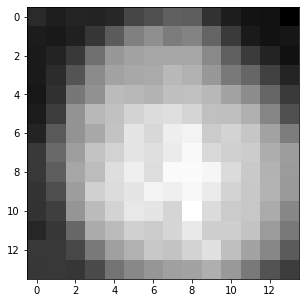

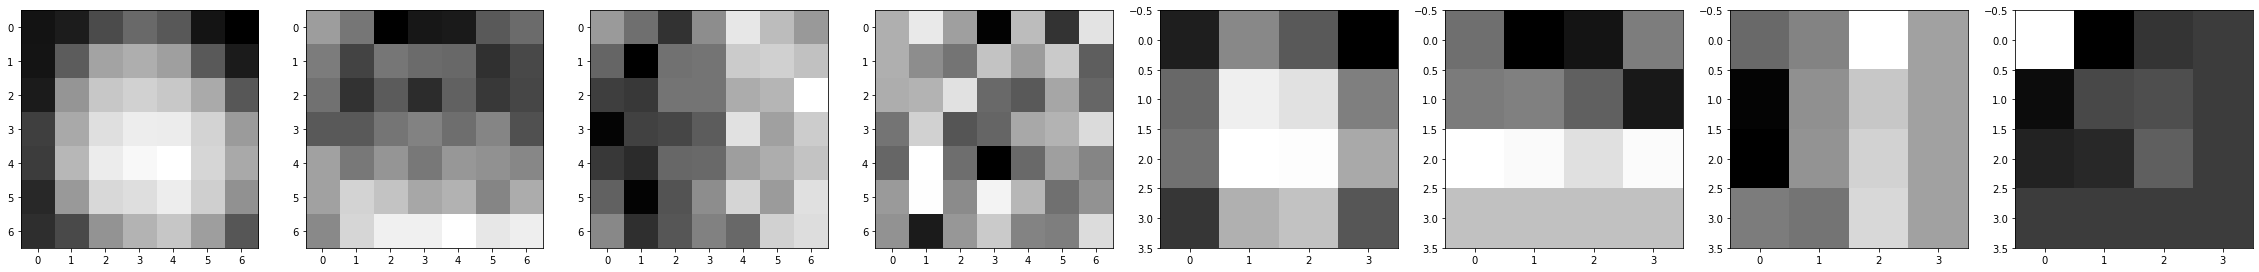

In [8]:
image = min_max_norm(db[img_idx]['img'])
patch_size = 14
patch_x1, patch_x2, patch_y1, patch_y2 = crop_center_coords(h1_circles[0][0], h1_circles[0][1], image.shape, patch_size//2)
image_patch = image[patch_y1:patch_y2, patch_x1:patch_x2]
decomp = get_wavelet_decomp(image_patch)
plt.figure(figsize=(5,5))
plt.imshow(image_patch,cmap='gray')
plt.show()
f,ax = plt.subplots(1,8,figsize=(40,5))
for idx,dec in enumerate(decomp):
    ax[idx].imshow(dec,cmap='gray')

In [25]:
patch_size = 14
patch_x1, patch_x2, patch_y1, patch_y2 = crop_center_coords(h1_circles[0][0], h1_circles[0][1], image.shape, patch_size//2)
image_patch_14 = image[patch_y1:patch_y2, patch_x1:patch_x2]

#feat_p30 = pd.DataFrame([get_wavelet_features(image_patch_30)])
feat_p14 = pd.DataFrame([get_wavelet_features(image_patch_14)])
feat_p14_dir2 = pd.DataFrame([get_wavelet_features(image_patch_14,[0, np.pi/4, np.pi/2])])
#features = pd.concat([feat_p30,feat_p14])

In [16]:
feat_p14

patch_mean_LL1  patch_skew_LL1  patch_std_LL1  patch_kur_LL1  \
0    80578.599103       -0.300952    9431.654336      -1.223755   

   patch_entropy_LL1  patch_uniformity_LL1  patch_relsmooth_LL1  \
0            5.61471              0.020408             0.999894   

   patch_mean_LH1  patch_skew_LH1  patch_std_LH1  ...  \
0     -243.848021        0.265276    1695.603368  ...   

   patch_glcm_contrast_HH1_0  patch_glcm_contrast_HH1_pi  \
0                     6308.2                      6308.2   

   patch_glcm_dissimilarity_HH1_0  patch_glcm_dissimilarity_HH1_pi  \
0                       59.228571                        59.228571   

   patch_glcm_ASM_HH1_0  patch_glcm_ASM_HH1_pi  patch_glcm_entropy_HH1  \
0              0.028571               0.028571           -3.203427e-16   

   patch_glcm_uniformity_HH1  patch_glcm_sum_squares_HH1  \
0                        1.0                         0.0   

   patch_glcm_autocorrelation_HH1  
0                             0.0  

[1 rows x 104 columns]

In [26]:
feat_p14_dir2

patch_mean_LL1  patch_skew_LL1  patch_std_LL1  patch_kur_LL1  \
0    80578.599103       -0.300952    9431.654336      -1.223755   

   patch_entropy_LL1  patch_uniformity_LL1  patch_relsmooth_LL1  \
0            5.61471              0.020408             0.999894   

   patch_mean_LH1  patch_skew_LH1  patch_std_LH1  ...  \
0     -243.848021        0.265276    1695.603368  ...   

   patch_glcm_dissimilarity_HH1_0  patch_glcm_dissimilarity_HH1_pi_o4  \
0                       59.228571                           75.861111   

   patch_glcm_dissimilarity_HH1_pi_o2  patch_glcm_ASM_HH1_0  \
0                           68.371429              0.028571   

   patch_glcm_ASM_HH1_pi_o4  patch_glcm_ASM_HH1_pi_o2  patch_glcm_entropy_HH1  \
0                  0.027778                  0.028571           -3.203427e-16   

   patch_glcm_uniformity_HH1  patch_glcm_sum_squares_HH1  \
0                        1.0                         0.0   

   patch_glcm_autocorrelation_HH1  
0                             0.0  

[1 rows x 122 columns]

In [23]:
res = [str(i) for i in [0,np.pi]]
res

['0', '3.141592653589793']

### GLCM

In [13]:
from general_utils.utils import min_max_norm
from skimage import feature

In [28]:
image = db[0]['img']
# not sure if agnles are what I need to get left<->right with d=2
image_patch = min_max_norm(image[300:330, 330:360], max_val=255).astype(np.uint8) # needs conversion for GLCM generation

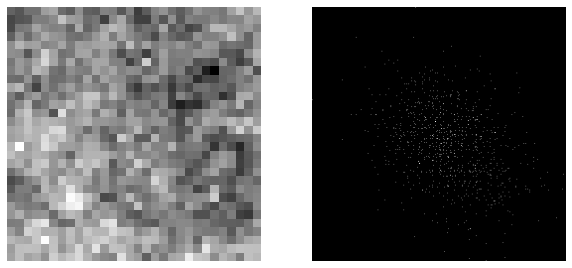

In [32]:
simple_im_show2(image_patch, feature.greycomatrix(image_patch, [2], [0, np.pi])[:,:,0,0])

In [35]:
glcm_distancs = [2]
glcm_angles = [0, np.pi]
glcm = feature.greycomatrix(image_patch, glcm_distancs, glcm_angles)
glcm.shape

(256, 256, 1, 2)

In [41]:
glcm_features = {}

skimage_glcm_features = ['energy','correlation','homogeneity','contrast','dissimilarity','ASM']
for feature_name in skimage_glcm_features:
    feature_values = feature.greycoprops(glcm, prop=feature_name)
    for fv_idx, fv in enumerate(feature_values.ravel()):
        glcm_features[f'glcm_{feature_name}_{fv_idx}'] = fv

In [50]:
glcm.shape

(256, 256, 1, 2)

In [42]:
def compute_custom_glcm_featurs(G):
    entropy, uniformity = CandidatesFeatureExtraction.entropy_uniformity(G)
    # sum average?
    # sum entropy?
    # difference entropy?
    sum_squares = (G*(1- G.mean())**2).sum()
    inverse_diff = 0
    idx_grid = np.indices((G.shape[0], G.shape[1]))
    autocorrelation = (idx_grid[0, :, :]*idx_grid[1, :, :]*G).sum()
    

{'glcm_energy_0': 0.03626558621839956,
 'glcm_energy_1': 0.03626558621839956,
 'glcm_correlation_0': 0.34565349040842414,
 'glcm_correlation_1': 0.3456534904084243,
 'glcm_homogeneity_0': 0.029272673048637537,
 'glcm_homogeneity_1': 0.029272673048637555,
 'glcm_contrast_0': 1901.1630952380947,
 'glcm_contrast_1': 1901.1630952380963,
 'glcm_dissimilarity_0': 34.70357142857142,
 'glcm_dissimilarity_1': 34.703571428571436,
 'glcm_ASM_0': 0.001315192743764172,
 'glcm_ASM_1': 0.0013151927437641717}